# Toxic comments classification for online store using BERT

In [11]:
import pandas as pd
import numpy as np 
np.random.seed(seed=42)
import time
from tqdm import notebook

import torch
import transformers 

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_val_score
from sklearn.utils.class_weight import compute_class_weight
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, roc_auc_score, roc_curve, auc

from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier


from IPython.display import display
import pprint
import matplotlib.pyplot as plt
import seaborn as sns

Let's import and study data. We have to solve the problem of binary classification. We need to get features from text and determine whether comment is a toxic (negative) or not.

In [4]:
try:
    df = pd.read_csv('/Users/anshilina/Downloads/toxic_comments.csv').drop('Unnamed: 0', axis=1)
except:
    df = pd.read_csv('/datasets/toxic_comments.csv').drop('Unnamed: 0', axis=1)
    
display(df.head())

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159292 non-null  object
 1   toxic   159292 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ MB


In [5]:
display(df.describe())

,toxic
count,159292.000000
mean,0.101612
std,0.302139
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


There are no missing values and duplicates in data frame.

In [5]:
print('Number of missing values:', df.isna().sum().sum())

Number of missing values: 0


In [6]:
print('Number of duplicates:', df.duplicated().sum())

Number of duplicates: 0


Let's visualize distribution of the target variable. We can observe that classes are imbalanced - there are more positive comments than toxic ones. When fitting models, it is necessary to take into account the imbalance. To do this, we will use special parameters of the models.

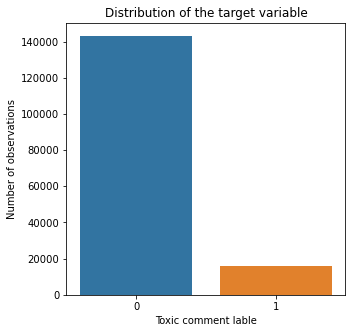

In [7]:
plt.figure(figsize=(5,5))
sns.barplot(data=df, x=df['toxic'].value_counts().index, y=df['toxic'].value_counts().values)
plt.xlabel('Toxic comment lable')
plt.ylabel('Number of observations')
plt.title('Distribution of the target variable')
plt.show()

## Data preprocessing

At the first stage, let's initialize tokenizer using which we will get tokens from texts.

In [91]:
tokenizer = transformers.BertTokenizer.from_pretrained('unitary/toxic-bert')

We need to cut the sentences since BERT can deal with maximum 512 tokens. Therefore, for predicting label of the comment we cannot use the whole sentence and we will take only its first part (`max_length = 512`). We also add special tokens – the beginning and the end of the sentence.

In [92]:
tokenized = []
for i in notebook.tqdm(range(df['text'].shape[0])):
    tokenized.append(tokenizer.encode(df['text'][i], max_length=512, truncation=True, add_special_tokens=True))

  0%|          | 0/159292 [00:00<?, ?it/s]

In [93]:
print('First five tokens of the first text:', tokenized[0][:5])

First five tokens of the first text: [101, 7526, 2339, 1996, 10086]


In [94]:
max_vector = max(len(token) for token in tokenized)
print('Maximum length of the token:', max_vector)

Maximum length of the token: 512


In [31]:
padded = np.array([i + [0]*(max_vector - len(i)) for i in tokenized])

Let's show to the model that zeros are insignificant tokens.

In [32]:
attention_mask = np.where(padded != 0, 1, 0)

Next we initialize `BertConfig` configuration and `BertModel`. We will use pre-trained model and configuration `unitary/toxic-bert`.

In [10]:
config = transformers.BertConfig.from_pretrained('unitary/toxic-bert')
model = transformers.BertModel.from_pretrained('unitary/toxic-bert', config=config)

Some weights of the model checkpoint at unitary/toxic-bert were not used when initializing BertModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Let's use only part of the data and get embeddings. 

In [72]:
idx = np.random.randint(padded.shape[0], size=4000)
padded = padded[idx, :]
df_new = df.iloc[idx].copy()

In [ ]:
batch_size = 5
embeddings = []

for i in notebook.tqdm(range(padded.shape[0] // batch_size)):
    
    batch = torch.LongTensor(padded[batch_size*i:batch_size*(i+1)])
    attention_mask_batch = torch.LongTensor(attention_mask[batch_size*i:batch_size*(i+1)]) 
    
    with torch.no_grad():
        batch_embeddings = model(batch, attention_mask=attention_mask_batch)
    embeddings.append(batch_embeddings[0][:,0,:].numpy()) 

  0%|          | 0/800 [00:00<?, ?it/s]

In [64]:
features = np.concatenate(embeddings)
train_features, test_features, train_target, test_target = train_test_split(
    features, df_new['toxic'], test_size=0.1, shuffle=True)

## Model fitting

We will fit Logistic Regression, Random Rorest Classifier, CatBoost, LightGBM, and XGBoost models. We will consider Decision Tree Classifier as the baseline and will compare quality of predictions made by other classifiers with its.

Let's use stratified division into folds for searching parameters and fitting model. In other words, on cross-validation, we will divide data into a train and validation sample, taking into account the initial proportion of classes.

In [66]:
k_fold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

We use the `class_weight` parameter to deal with imbalance.

### Decision Tree Classifier

In [67]:
tree_model = DecisionTreeClassifier(random_state=42, class_weight='balanced')
tree_params = {
    'max_depth' : range(2, 13, 2),
    'min_samples_leaf' : range(1, 5),
    'min_samples_split': range(2, 10, 2),
}
tree_model = GridSearchCV(tree_model, param_grid=tree_params, cv=k_fold, scoring='f1', n_jobs=-1)

In [68]:
tree_start = time.time()
tree_model.fit(train_features, train_target)
tree_grid_time = time.time() - tree_start

In [69]:
print('Results of grid search.\n')
print(f'Grid search time: {round(tree_grid_time/60, 2)} min')
print(f'Fitting time: {round(tree_model.cv_results_["mean_fit_time"][tree_model.best_index_], 5)} s')
print(f'Prediction time: {round(tree_model.cv_results_["mean_score_time"][tree_model.best_index_], 5)} s')
print(f'Best parameters: {tree_model.best_params_}')
print(f'F1 on cross-validation:{tree_model.best_score_}')

Results of grid search.

Grid search time: 2.47 min
Fitting time: 3.19986 s
Prediction time: 0.01463 s
Best parameters: {'max_depth': 12, 'min_samples_leaf': 1, 'min_samples_split': 6}
F1 on cross-validation:0.3874470345462332


### Logistic Regression

In [70]:
log_model = LogisticRegression(solver='liblinear', class_weight='balanced')
log_params = {
    'C':range(5,25,5),
}
log_model = GridSearchCV(log_model, param_grid=log_params, cv=k_fold, scoring='f1', n_jobs=-1)

In [71]:
log_start = time.time()
log_model.fit(train_features, train_target)
log_grid_time = time.time() - log_start

In [72]:
print('Results of grid search.\n')
print(f'Grid search time: {round(log_grid_time, 2)} s')
print(f'Fitting time: {round(log_model.cv_results_["mean_fit_time"][log_model.best_index_], 5)} s')
print(f'Prediction time: {round(log_model.cv_results_["mean_score_time"][log_model.best_index_], 5)} s')
print(f'Best parameters: {log_model.best_params_}')
print(f'F1 on cross-validation:{log_model.best_score_}')

Results of grid search.

Grid search time: 23.35 s
Fitting time: 4.76468 s
Prediction time: 0.01382 s
Best parameters: {'C': 20}
F1 on cross-validation:0.6482478870719257


### Random Forest Classifier

In [73]:
forest_model = RandomForestClassifier(random_state=42, class_weight='balanced')
forest_params = {
    'max_depth' : range(5, 10, 1),
    'n_estimators': range(10, 50, 10),
}
forest_model = GridSearchCV(forest_model, param_grid=forest_params, cv=k_fold, scoring='f1', n_jobs=-1)

In [74]:
forest_start = time.time()
forest_model.fit(train_features, train_target)
forest_grid_time = time.time() - forest_start

In [75]:
print('Results of grid search.\n')
print(f'Grid search time: {round(forest_grid_time, 2)} s')
print(f'Fitting time: {round(forest_model.cv_results_["mean_fit_time"][forest_model.best_index_], 5)} s')
print(f'Prediction time: {round(forest_model.cv_results_["mean_score_time"][forest_model.best_index_], 5)} s')
print(f'Best parameters: {forest_model.best_params_}')
print(f'F1 on cross-validation: {forest_model.best_score_}')

Results of grid search.

Grid search time: 22.27 s
Fitting time: 1.95162 s
Prediction time: 0.02507 s
Best parameters: {'max_depth': 8, 'n_estimators': 30}
F1 on cross-validation: 0.4521852425849041


Next we fit gradient boosting models. Firstly, we calculate weights of each class that we will use in models to solve the imbalance problem while fitting Cat Boost and LightGBM.

In [31]:
classes = np.unique(train_target)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=train_target)
class_weights = dict(zip(classes, weights))

### Cat Boost Classifier

In [76]:
cat_model = CatBoostClassifier(class_weights=class_weights, random_seed=42, loss_function='Logloss', silent=True)

In [77]:
cat_start = time.time()
cat_model.fit(train_features, train_target)
cat_fit_time = time.time() - cat_start

In [78]:
cat_start = time.time()
cat_model.predict(train_features)
cat_pred_time = time.time() - cat_start

In [79]:
print('Fitting results.\n')
print(f'Fitting time: {round(cat_fit_time/60, 5)} min')
print(f'Prediction time: {round(cat_pred_time, 5)} s')
print('F1 on validation:', np.mean(cross_val_score(
    cat_model, train_features, train_target, cv=k_fold, scoring='f1', n_jobs=-1)))

Fitting results.

Fitting time: 1.23192 min
Prediction time: 0.03911 s
F1 on validation: 0.6684534465595489


### LGBM Classifier

In [80]:
lgbm_model = LGBMClassifier(class_weight=class_weights, random_state=42, n_jobs=-1)
lgbm_params = {
    'learning_rate': [0.03, 0.1],
    'n_estimators': range(80, 100, 5),
}
lgbm_model = GridSearchCV(lgbm_model, param_grid=lgbm_params, cv=k_fold, scoring='f1', n_jobs=-1)

In [81]:
lgbm_start = time.time()
lgbm_model.fit(train_features, train_target)
lgbm_search_time = time.time() - lgbm_start

In [82]:
print('Results of grid search.\n')
print(f'Grid search time: {round(lgbm_search_time/60, 2)} min')
print(f'Fitting time: {round(lgbm_model.cv_results_["mean_fit_time"][lgbm_model.best_index_], 5)} s')
print(f'Prediction time: {round(lgbm_model.cv_results_["mean_score_time"][lgbm_model.best_index_], 5)} s')
print(f'Best parameters: {lgbm_model.best_params_}')
print(f'F1 on cross-validation: {lgbm_model.best_score_}')

Results of grid search.

Grid search time: 1.68 min
Fitting time: 16.68016 s
Prediction time: 0.04402 s
Best parameters: {'learning_rate': 0.1, 'n_estimators': 80}
F1 on cross-validation: 0.6432649154554059


### XGBoost Classifier

In [83]:
xgb_class_weight = float(np.sum(train_target == 0) / np.sum(train_target == 1))

In [84]:
xgb_model = XGBClassifier(random_state=42, n_jobs=-1, scale_pos_weight=xgb_class_weight)
xgb_params = {
    'max_depth': range(6,10,2),
    'n_estimators': range(50,90,10),
}
xgb_model = GridSearchCV(xgb_model, param_grid=xgb_params, cv=k_fold, scoring='f1', n_jobs=-1)

In [85]:
xgb_start = time.time()
xgb_model.fit(train_features, train_target)
xgb_search_time = time.time() - xgb_start

In [87]:
print('Results of grid search.\n')
print(f'Grid search time: {round(xgb_search_time/60, 2)} min')
print(f'Fitting time: {round(xgb_model.cv_results_["mean_fit_time"][xgb_model.best_index_], 5)} s')
print(f'Prediction time: {round(xgb_model.cv_results_["mean_score_time"][xgb_model.best_index_], 5)} s')
print(f'Best parameters: {xgb_model.best_params_}')
print(f'F1 on cross-validation:', xgb_model.best_score_)

Results of grid search.

Grid search time: 4.46 min
Fitting time: 55.62909 s
Prediction time: 0.10823 s
Best parameters: {'max_depth': 6, 'n_estimators': 80}
F1 on cross-validation: 0.6248082911885103


**Summary:** CatBoost Classifier showed the best results on cross validation, although its learning rate is the slowest. Summary of the results are presented in the table.

|Model|Fitting time|Prediction time| F1 score|
|:---|:---|:---|:---|
|CatBoost |1.2 min|0.04 s|0.69|
|Logistic regression |4.8 s|0.01 s|0.65|
|LightGBM |16.7 s|0.04 s|0.64|
|XGBoost |55.6 s|0.11 s|0.62|
|Random Forest |2 s|0.02 s|0.45|
|Decision Tree |3.2 s|0.01 s|0.39|

## Model testing

In [88]:
print('Predictions of the CatBoost classifier on the test sample.\n')
print('F1 score on test:', f1_score(test_target, cat_model.predict(test_features)))

Predictions of the CatBoost classifier on the test sample.

F1 score on test: 0.85


In [89]:
proba_test = cat_model.predict_proba(test_features)[:,1]
print('AUC-ROC:', roc_auc_score(test_target, proba_test))

AUC-ROC: 0.9574334898278559


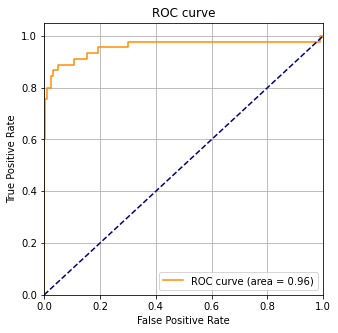

In [90]:
fpr, tpr, treshold = roc_curve(test_target, proba_test)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(5,5))
plt.plot(fpr, tpr, color='darkorange',
         label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc="lower right")
plt.grid()
plt.show()

## Conclusion

In this project, we classified comments into toxic and non-toxic. The target quality of the prediction model was achieved - the quality on the test sample (F1 score) is 0.85.

At the first stage, we obtained features from the text. Words in texts were tokenized. Then, we got embeddings using BERT model (toxic bert classification). While preprocessin data, we discovered imbalance of the classes - there are more non-toxic comments than toxic ones. We tried to overcome this problem by setting the appropriate parameters of the models.

Finally, we fitted six models - Decision Tree Classifier, Random Forest Classifier, Logistic Regression, and gradient boosting models: CatBoost, LightGBM, XGBoost. We compared the quality of those models and their learning rate and prediction time. As the result, **CatBoost Classifier** was chosen as the final model and we suggest to use it to detect toxic comments.